In [1]:
import numpy as np
import cupy as np
from matplotlib import pyplot as plt
# ----- Cord for importing .ipynb file as module -----
import sys  
import notebookutil as nbu
sys.meta_path.append(nbu.NotebookFinder())
# ----------------------------------------------------
from activations import *
from loss_functions import *
from optimizer import *
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from typing import Callable, Any, List, Dict

class cnn_module:
    def __init__(self, structure:List, init_weight_range:float):
        self.params = {}
        self.conv_params = {}
        self.pool_params = {}
        self.grads = {}
        self.outputs = {}
        self.activations = {}
        self.L = len(structure)
        for l in range(self.L):
            if structure[l][0] == 'conv':
                in_channel = structure[l][1]
                out_channel = structure[l][2]
                kernel_size = structure[l][3]
                W = np.random.uniform(
                    low = - init_weight_range,
                    high = init_weight_range,
                    size = (out_channel, in_channel, kernel_size, kernel_size)
                )
                b = np.zeros((1, 1, out_channel))
                self.params['conv_W' + str(l)] = W
                self.params['conv_b' + str(l)] = b
                forward_l = 'forward_' + str(l)
                backward_l = 'backward_' + str(l)
                self.activations[forward_l] = structure[l][4]
                self.activations[backward_l] = structure[l][5]
                setattr(self, forward_l, self.forward_conv)
                setattr(self, backward_l, self.backward_conv)
        
            elif structure[l][0] == 'pool':
                self.pool_params['kernel_size' + str(l)] = structure[l][1]
                forward_l = 'forward_' + str(l)
                backward_l = 'backward_' + str(l)
                setattr(self, forward_l, self.forward_pool)
                setattr(self, backward_l, self.backward_pool)
                
            elif structure[l][0] == 'fc':
                in_size = structure[l][1]
                out_size = structure[l][2]
                W = np.random.uniform(
                    low = - init_weight_range,
                    high = init_weight_range,
                    size = (in_size, out_size)
                )
                b = np.zeros((1, out_size))
                self.params['fc_W' + str(l)] = W
                self.params['fc_b' + str(l)] = b
                forward_l = 'forward_' + str(l)
                backward_l = 'backward_' + str(l)
                self.activations[forward_l] = structure[l][3]
                self.activations[backward_l] = structure[l][4]
                setattr(self, forward_l, self.forward_fc)
                setattr(self, backward_l, self.backward_fc)
    
    def forward_conv(self, x:np.array, num_layer:int, slide_size=1) -> np.array:
        W = self.params['conv_W' + str(num_layer)]
        b = self.params['conv_b' + str(num_layer)]
        N, in_channel, H_in, W_in = x.shape
        out_channel, in_channel, kernel_size = W.shape[:3]
        H_out = int((H_in - kernel_size) / slide_size) + 1
        W_out = int((W_in - kernel_size) / slide_size) + 1
        params = [kernel_size, slide_size, N, in_channel, H_in, W_in, out_channel, H_out, W_out]
        self.conv_params['params' + str(num_layer)] = params
        patch = np.zeros((N, H_out * W_out, in_channel, kernel_size, kernel_size))
        for h in range(0, H_out, slide_size):
            for w in range(0, W_out, slide_size):
                hs = h
                he = hs + kernel_size
                ws = w
                we = ws + kernel_size
                patch[:, h * W_out + w, :, :, :] = x[:, :, hs:he, ws:we]
        Z = np.tensordot(patch, W, ([2, 3, 4], [1, 2, 3])) + b
        Z = Z.swapaxes(1, 2).reshape(N, out_channel, H_out, W_out)
        A = self.activations['forward_' + str(num_layer)](Z)
        self.conv_params['conv_patch' + str(num_layer)] = patch
        self.outputs['Z' + str(num_layer)] = Z
        self.outputs['A' + str(num_layer)] = A
        return A

    def backward_conv(self, dA:np.array, num_layer:int):
        W = self.params['conv_W' + str(num_layer)]
        Z = self.outputs['Z' + str(num_layer)]
        patch = self.conv_params['conv_patch' + str(num_layer)]
        params = self.conv_params['params' + str(num_layer)]
        kernel_size, slide_size, N, in_channel, H_in, W_in, out_channel, H_out, W_out = params
        dZ = dA * self.activations['backward_' + str(num_layer)](Z)
        dZ = dZ.reshape(N, out_channel, H_out * W_out).swapaxes(1, 2)
        dW = np.tensordot(dZ, patch, ([0, 1], [0, 1]))
        db = np.sum(dZ, axis=(0, 1), keepdims=True)
        # --------------------------------------------------------------
        assert(dW.shape == self.params['conv_W' + str(num_layer)].shape)
        assert(db.shape == self.params['conv_b' + str(num_layer)].shape)
        # --------------------------------------------------------------        
        self.grads['conv_W' + str(num_layer)] = dW
        self.grads['conv_b' + str(num_layer)] = db
        dA_ = np.tensordot(dZ, W, (2, 0))
        dA = np.zeros((N, in_channel, H_in, W_in))
        for h in range(0, H_out, slide_size):
            for w in range(0, W_out, slide_size):
                hs = h
                he = hs + kernel_size
                ws = w
                we = ws + kernel_size
                dA[:, :, hs:he, ws:we] = dA_[:, h * W_out + w, :, :, :]
        return dA

    def forward_pool(self, x:np.array, num_layer:int) -> np.array:
        kernel_size = self.pool_params['kernel_size' + str(num_layer)]
        slide_size = kernel_size
        N, n_channel, H_in, W_in = x.shape
        H_out = int((H_in - kernel_size) / slide_size) + 1
        W_out = int((W_in - kernel_size) / slide_size) + 1
        params = [kernel_size, slide_size, N, n_channel, H_in, W_in, H_out, W_out]
        self.pool_params['params' + str(num_layer)] = params
        patch = np.zeros((N, H_out * W_out, n_channel, kernel_size, kernel_size))
        for h in range(0, H_out, slide_size):
            for w in range(0, W_out, slide_size):
                hs = h
                he = hs + kernel_size
                ws = w
                we = ws + kernel_size
                patch[:, h * W_out + w, :, :, :] = x[:, :, hs:he, ws:we]
        patch = patch.swapaxes(1, 2).reshape(N, n_channel, H_out * W_out, kernel_size * kernel_size)
        A = np.max(patch, axis=3).reshape(N, n_channel, H_out, W_out)
        index = np.argmax(patch, axis=3).flatten()
        self.pool_params['index' + str(num_layer)] = index
        self.outputs['A' + str(num_layer)] = A
        return A
    
    def backward_pool(self, delta:np.array, num_layer:int):
        params = self.pool_params['params' + str(num_layer)]
        kernel_size, slide_size, N, n_channel, H_in, W_in, H_out, W_out = params
        index_flat = self.pool_params['index' + str(num_layer)]
        rh, rw = int(H_in / H_out), int(W_in / W_out)
        #--------------------------------------------------
        assert(H_in % H_out == 0 and W_in % W_out == 0)
        #--------------------------------------------------
        index = np.arange(N * n_channel * H_out * W_out) * rh * rw + index_flat
        delta_flatten = np.zeros(N * n_channel * H_in * W_in)
        delta_flatten[index] = delta.flatten()
        return delta_flatten.reshape(N, n_channel, H_in, W_in)
                
    def forward_fc(self, x:np.array, num_layer:int) -> np.array:
        W = self.params['fc_W' + str(num_layer)]
        b = self.params['fc_b' + str(num_layer)]
        N = x.shape[0]
        in_size = W.shape[0]
        x = x.flatten().reshape(N, in_size)
        Z = np.dot(x, W) + b
        A = self.activations['forward_' + str(num_layer)](Z)
        self.outputs['Z' + str(num_layer)] = Z
        self.outputs['A' + str(num_layer)] = A
        return A
    
    def backward_fc(self, dA:np.array, num_layer:int):
        W = self.params['fc_W' + str(num_layer)]
        b = self.params['fc_b' + str(num_layer)]
        Z = self.outputs['Z' + str(num_layer)]
        N = dA.shape[0]
        A_prev = self.outputs['A' + str(num_layer - 1)].reshape(N, -1)
        dZ = dA * self.activations['backward_' + str(num_layer)](Z)
        dW = np.dot(A_prev.T, dZ)
        db = np.sum(dZ, axis=0, keepdims=True)
        # --------------------------------------------------------------
        assert(dW.shape == self.params['fc_W' + str(num_layer)].shape)
        assert(db.shape == self.params['fc_b' + str(num_layer)].shape)
        # --------------------------------------------------------------        
        self.grads['fc_W' + str(num_layer)] = dW
        self.grads['fc_b' + str(num_layer)] = db
        dA = np.dot(dZ, W.T)
        return dA
    
    def forward_propagate(self, x:np.array):
        self.outputs['A0'] = x
        for l in range(self.L):
            forward_l = 'forward_' + str(l)
            x = getattr(self, forward_l)(x, l)
#             print(l, x.shape)
        return x
    
    def back_propagate(self, dA:np.array):
        for l in reversed(range(self.L)):
            backward_l = 'backward_' + str(l)
            dA = getattr(self, backward_l)(dA, l)
#             print(l, dA.shape)


In [35]:
# ir = (6 / (28 * 28 + 10)) ** 0.5
# x = np.random.uniform(low=-ir, high=ir, size=(5, 1, 28, 28)) + 0.5
# y = np.random.uniform(low=-ir, high=ir, size=(5, 10)) +0.5
# structure = [
#     ['conv', 1, 6, 5, relu, d_relu],    # (N, 1, 28, 28) -> (N, 6, 24, 24)
#     ['pool', 2],                        # (N, 6, 24, 24) -> (N, 6, 12, 12)
#     ['conv', 6, 16, 3, relu, d_relu],   # (N, 6, 12, 12) -> (N, 16, 10, 10)
#     ['pool', 2],                        # (N, 16, 10, 10) -> (N, 16, 5, 5)
#     ['fc', 16*5*5, 120, relu, d_relu],  # (N, 16, 5, 5) -> (N, 120)
#     ['fc', 120, 84, relu, d_relu],      # (N, 120) -> (N, 84)
#     ['fc', 84, 10, softmax, d_softmax]  # (N, 84) -> (N, 10)
# ]
# cnn = cnn_module(structure, ir)
# optimizer = Adam(cnn)
# y_pred = cnn.forward_propagate(x)
# loss, dA = CEL(y_pred, y)
# cnn.back_propagate(dA)
# optimizer.update_params()
# print(loss, dA)

In [2]:
if __name__ == '__main__':
    # Load data set
    mnist = fetch_openml('mnist_784', data_home='./')
#     X = mnist.data / 255
    X = mnist.data[:7000] / 255
    Y = []
#     for num in mnist.target:
    for num in mnist.target[:7000]:
        zeros = np.zeros(10)
        zeros[int(num)] = 1.0
        Y.append(zeros)
    Y = np.array(Y)
    print(X.shape, Y.shape)


(7000, 784) (7000, 10)


0.00869291381699617
Teach data: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


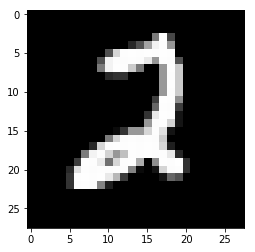

In [9]:
if __name__ == '__main__':
    # Set cnn
    init_weight_range = (6 / (28 * 28 + 10)) ** 0.5 * 0.1
    structure = [
        ['conv', 1, 6, 5, relu, d_relu],    # (N, 1, 28, 28) -> (N, 6, 24, 24)
        ['pool', 2],                        # (N, 6, 24, 24) -> (N, 6, 12, 12)
        ['conv', 6, 16, 3, relu, d_relu],   # (N, 6, 12, 12) -> (N, 16, 10, 10)
        ['pool', 2],                        # (N, 16, 10, 10) -> (N, 16, 5, 5)
        ['fc', 16*5*5, 120, relu, d_relu],  # (N, 16, 5, 5) -> (N, 120)
        ['fc', 120, 84, relu, d_relu],      # (N, 120) -> (N, 84)
        ['fc', 84, 10, softmax, d_softmax]  # (N, 84) -> (N, 10)
    ]
    cnn = cnn_module(structure, init_weight_range)
    optimizer = SGD(cnn, 0.5)
#     optimizer = Adam(cnn)
    print(init_weight_range)
    # Prepare train & test data
    N = X.shape[0]
    rate = 1 / 7
    N_test = int(N * rate)
    N_train = N - N_test
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=rate)
    X_train = X_train.reshape(N_train, 1, 28, 28)
    Y_train = Y_train.reshape(N_train, 10)
    X_test = X_test.reshape(N_test, 1, 28, 28)
    Y_test = Y_test.reshape(N_test, 10)
    # Plot example of data & label
    print('Teach data:', Y_train[0, :])
    plt.figure()
    plt.imshow(X_train[0, 0, :, :])
    plt.gray()    
    
# x = torch.tensor(x, dtype=torch.float32)
# y = torch.tensor(y, dtype=torch.int64)
# y_pred = cnn.forward_propagate(x)
# print(y_pred.shape, y_pred[0])
# loss, dA = CEL(y_pred, y)
# print(dA.shape, loss)
# cnn.back_propagate(dA)


In [10]:
if __name__ == '__main__':
    # Learning data
    epoches = 100
    batch_size = 500
    Loss_train = []
    Loss_test = []
    train_n_batches = len(X_train) // batch_size
    test_n_batches = len(X_test) // batch_size
    for epoch in range(1, epoches + 1):
        loss_train = []
        X_train, Y_train = shuffle(X_train, Y_train)
        for i in range(train_n_batches):
            start = i * batch_size
            end = start + batch_size
            y_pred = cnn.forward_propagate(X_train[start:end])
            loss, delta = CEL(y_pred, Y_train[start:end])
            cnn.back_propagate(delta)
            optimizer.update_params()
            loss_train.append(loss)
        loss_test = []
        X_test, Y_test = shuffle(X_test, Y_test)
        for i in range(test_n_batches):
            start = i * batch_size
            end = start + batch_size
            y_pred = cnn.forward_propagate(X_test[start:end])
            loss, delta = CEL(y_pred, Y_test[start:end])
            loss_test.append(loss)
        Loss_train.append(np.mean(loss_train))
        Loss_test.append(np.mean(loss_test))
        if epoch % 1 == 0 or epoch == 1:
            print('Epoch:', epoch,
                  '  Train Loss:', '{:.4f}'.format(Loss_train[-1]),
                  '  Test Loss:', '{:.4f}'.format(Loss_test[-1])
                 )

Epoch: 1   Train Loss: 2.3016   Test Loss: 2.3040
Epoch: 2   Train Loss: 2.3000   Test Loss: 2.3071
Epoch: 3   Train Loss: 2.3009   Test Loss: 2.3165
Epoch: 4   Train Loss: 2.5555   Test Loss: nan
Epoch: 5   Train Loss: nan   Test Loss: nan
Epoch: 6   Train Loss: nan   Test Loss: nan
Epoch: 7   Train Loss: nan   Test Loss: nan
Epoch: 8   Train Loss: nan   Test Loss: nan


KeyboardInterrupt: 

(1, 2, 1)
